# Zielstellung

Ziel dieses Notebooks ist es, ein Machine Learning Modell zu entwerfen, welches das Gehalt einer Stelle bestmöglich aus den Angaben in der Jobbeschreibung vorhersagen soll.
Vorgehen:
- Test einer schwachen Baseline ==> Mittelwert aller Gehälter als Vorhersage nutzen
- Test eines linearen Modelles
- Test eines nichtlinearen Modelles

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GroupKFold, train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from category_encoders.target_encoder import TargetEncoder

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [2]:
df = pd.read_csv("data2/cleaned_wide.csv")
df.dropna(subset=["average_salary"], inplace=True)
df.head()

,link,company,title,content,rating,num_ratings,company_link,release_date,company_size,permanent_employment,...,no_degree_info,computer_science,math/statistics,natural_science,engineering,business,little_experience,much_experience,no_experience_information,some_experience
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,True,False,True,False,False,True,False,False,True,False
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,True,False,True,False,False,True,False,False,True,False
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,We create the future of B2B commerce by giving...,NaN,NaN,NaN,2022-06-01,NaN,True,...,False,False,True,False,True,False,False,True,False,False
4,https://www.stepstone.de/stellenangebote--Busi...,R+V Allgemeine Versicherung AG,Business Analyst / Data Science (m/w/d),Wie sich die Versicherung von morgen anfühlen ...,4.4,247 Bewertungen,https://www.stepstone.de/cmp/de/R-V-Allgemeine...,2022-06-01,"10,001+",True,...,False,True,False,False,False,False,False,False,True,False
8,https://www.stepstone.de/stellenangebote--Data...,CHECK24,Data Science & Artificial Intelligence Manager...,CHECK24 ist eines der führenden Online-Unterne...,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-05-28,2501-5000,True,...,False,False,False,True,False,True,False,False,True,False


In [3]:
df.shape

(1687, 88)

Innerhabl der EDA wurden bereits Attribute identifiziert, die im Bezug auf das Gehalt einer Stelle nicht relevant sind. Diese werden bei der Modellbildung von Beginn an ausgeschlossen.

In [4]:
df.columns

Index(['link', 'company', 'title', 'content', 'rating', 'num_ratings',
       'company_link', 'release_date', 'company_size', 'permanent_employment',
       'trainee', 'home_office_possible', 'part_time', 'full_time',
       'title_category', 'experience_level', 'average_salary', 'main_location',
       'multiple_locations', 'main_region', 'main_industry', 'python', 'r',
       'sql', 'java', 'javascript', 'c', 'c++', 'c#', 'scala', 'julia',
       'matlab', 'swift', 'go', 'sas', 'perl', 'php', 'html', 'css', 'excel',
       'tableau', 'power_bi', 'spark', 'hadoop', 'hive', 'storm', 'snowflake',
       'knime', 'aws', 'kafka', 'azure', 'google_cloud', 'docker', 'git',
       'linux', 'kubernetes', 'jenkins', 'bigquery', 'gcp', 'airflow',
       'cassandra', 'alteryx', 'pandas', 'numpy', 'tensorflow/keras',
       'pytorch', 'matplotlib', 'seaborn', 'scikit-learn', 'plotly',
       'streamlit', 'spacy', 'nltk', 'scipy', 'statsmodels', 'master', 'phd',
       'bachelor', 'no_degree_info'

In [5]:
df.drop(["link", "title", "content", "rating", "num_ratings", "company_link", "release_date", "permanent_employment", "trainee", "full_time", 
        "python", "r", "sql", "java", "javascript", "c", "c++", "c#", "scala", "julia", "matlab", "swift", "go", "sas", "perl", "php", "html", "css", "excel",
        "tableau", "power_bi", "spark", "hadoop", "hive", "storm", "snowflake", "knime", "aws", "kafka", "azure", "google_cloud", "docker", "git",
        "linux", "kubernetes", "jenkins", "bigquery", "gcp", "airflow", "cassandra", "alteryx", "pandas", "numpy", "tensorflow/keras",
        "pytorch", "matplotlib", "seaborn", "scikit-learn", "plotly", "streamlit", "spacy", "nltk", "scipy", "statsmodels", "computer_science", "math/statistics",
        "natural_science", "engineering", "business"], axis=1, inplace=True)
df.columns

Index(['company', 'company_size', 'home_office_possible', 'part_time',
       'title_category', 'experience_level', 'average_salary', 'main_location',
       'multiple_locations', 'main_region', 'main_industry', 'master', 'phd',
       'bachelor', 'no_degree_info', 'little_experience', 'much_experience',
       'no_experience_information', 'some_experience'],
      dtype='object')

Um später eine unverzerrte Schätzung der Modellgüt zu erreichen, wird als ersten ein Teil der Daten als Testdaten abgesplittet und weggelegt.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train.shape, df_test.shape

((1349, 19), (338, 19))

Es existieren drei Attribute mit fehlenden Werten. Da es sich bei allen Attributen mit kategorische Features handelt, wurde sich dafür entschieden später jeweils eine zusätzliche Kategorie "missing" hinzuzufügen.

In [7]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

company_size                 345
main_industry                217
main_region                   31
no_experience_information      0
much_experience                0
little_experience              0
no_degree_info                 0
bachelor                       0
phd                            0
master                         0
dtype: int64

Die Targetvariable ist näherungsweise normalverteilt, enthält jedoch einen relativ extremen Ausreißer. Bei der Verwendung eines linearen Modelles kann es sinnvoll sein, diesen aus den Trainingsdaten zu entfernen, um die restlichen Datenpunkte besser zu approximieren.

<AxesSubplot:xlabel='average_salary', ylabel='Count'>

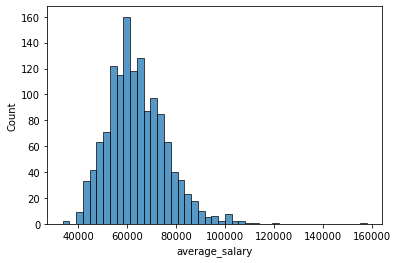

In [8]:
sns.histplot(x=df_train["average_salary"])

### Schwache Baseline

In [9]:
X = df_train.drop("average_salary", axis=1)
y = df_train["average_salary"]
model = DummyRegressor(strategy="mean")
results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 9328.610852440717
test score: 9331.5807791647


### Lineares Modell

In [10]:
df_train.columns

Index(['company', 'company_size', 'home_office_possible', 'part_time',
       'title_category', 'experience_level', 'average_salary', 'main_location',
       'multiple_locations', 'main_region', 'main_industry', 'master', 'phd',
       'bachelor', 'no_degree_info', 'little_experience', 'much_experience',
       'no_experience_information', 'some_experience'],
      dtype='object')

Im Rahmen der Vorverarbeitung werden alle fehlenden Werte zunächst durch die Kategorie "missing_value" ersetzt. Anschließend werden alle kategorischen Features mit One-Hot-Encoding in numerische Features umgewandelt. Eine Skalierung der Daten ist nicht notwendig, da der Datensatz nur kategorische Features enthält.

In [11]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", LinearRegression())
])

results = cross_validate(pipe, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 3119.777764331356
test score: 7104.9044378120725


Die Lineare Regression liefert bereits eine deutliche Verbesserung gegenüber der Baseline. Die große Differenz zwischen Trainings- u. Testfehler lässt jedoch darauf schließen, dass das Modell auf den Trainigsdaten overfittet. Daher wird als nächsten der Effekt zusätzlicher Regularisierung untersucht.

In [12]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", Lasso())
])

param_grid = {"model__alpha": list(range(0,50))}
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1)
grid.fit(X, y)

results = pd.DataFrame({"alpha": grid.cv_results_["params"], "train_error": np.abs(grid.cv_results_["mean_train_score"]), "test_error": np.abs(grid.cv_results_["mean_test_score"])})
results.loc[results["test_error"] == results["test_error"].min()]

,alpha,train_error,test_error
9,{'model__alpha': 9},5086.488276,6379.435049


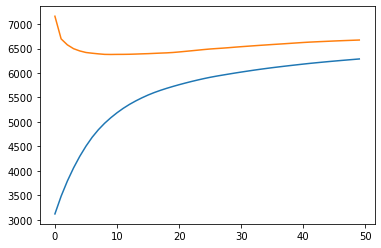

In [13]:
plt.plot(results["train_error"])
plt.plot(results["test_error"])

In [14]:
# bringt die Entfernung des Ausreißers eine Verbesserung?

In [15]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

kfold = KFold(5)
train_error_grid = []
test_error_grid = []
alpha_list = list(range(0,50))

for alpha in tqdm(range(0,50)):
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("model", Lasso(alpha=alpha))
    ])
    train_error = []
    test_error = []
    for train, test in kfold.split(X, y):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_train = X_train.loc[y_train<120000]
        y_train = y_train.loc[y_train<120000]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        pipe.fit(X_train, y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        train_error.append(mean_absolute_error(y_train, y_pred_train))
        test_error.append(mean_absolute_error(y_test, y_pred_test))

    train_error_grid.append(np.mean(train_error))
    test_error_grid.append(np.mean(test_error))
    pipe.fit(X,y)

results = pd.DataFrame({"alpha": alpha_list, "train_error": train_error_grid, "test_error": test_error_grid})
results.loc[results["test_error"] == results["test_error"].min()]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:58<00:00,  2.37s/it]


,alpha,train_error,test_error
9,9,5076.805744,6367.051075


Die Entfernung des Ausrteißers bringt noch einmal eine leichte Verbesserung auf den Testdaten mit sich, da die große Masse an Datenpunkten nun etwas besser dargestellt werden kann.

### Nichtlineares Modell

In [16]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

target_encoding = TargetEncoder()

pipe = Pipeline([
    ("encoder", None),
    ("model", XGBRegressor(random_state=0))
])

param_grid = {"encoder": [onehot_encoding, target_encoding],
              "model__n_estimators": [50, 100, 200, 500, 1000], 
              "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
              "model__max_depth": [5, 6, 7],
              "model__subsample": [0.5, 0.7, 0.9, 1],
              "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
              "model__reg_lambda": [0, 1, 3, 5, 10],
              "model__reg_alpha": [0, 1, 3, 5, 10],
              "model__gamma": [0, 1, 3, 5, 10],}
grid = RandomizedSearchCV(pipe, param_grid, n_iter=100, scoring="neg_mean_absolute_error", return_train_score=True, verbose=1, n_jobs=-1, random_state=0)
grid.fit(X, y)

print(np.abs(grid.best_score_))
grid.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
6329.217157790342


Pipeline(steps=[('encoder',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing_value',
                                                strategy='constant')),
                                 ('encoder',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.7, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=Fals...
                              gamma=5, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0,

Ein nichtlineares Modell brachte lediglich eine geringe Verbesserung gegenüber dem linearen Modell. Mit einer GridSearch hätte man eventuell noch eine leicht bessere Hyperparameterkombination finden können. Außerdem könnten andere Gradient Boosting Varianten wie LightGBM oder CatBoost noch einmal minimal besser abschneiden. Da die bisherigen Ergebnisse jedoch nicht darauf schließen lassen, dass ein nichtlineares Modell in diesem Szenario einen großen Mehrwert bietet, wird auf ein weiteres Tuning zugunsten der Performanz verzichtet.

Auf der anderen Seite liefert das lineare Modell kürzere Rechen- u. Inferenzzeiten, einen geringeren Speicherbedarf sowie eine bessere Interpretierbarkeit. Daher wurde sich in diesem Szenario für das lineare Modell entschieden.

### Auswertung

In [17]:
X_train = df_train.drop(["average_salary"], axis=1)
y_train = df_train["average_salary"]
X_test = df_test.drop(["average_salary"], axis=1)
y_test = df_test["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", Lasso(alpha=9))
])

X_train = X_train.loc[y_train<120000]
y_train = y_train.loc[y_train<120000]
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
print(f"Mean Absolute Error on Test Set: {mean_absolute_error(y_test, predictions)}")

Mean Absolute Error on Test Set: 7167.544235785074


Der Fehler auf den Testdaten ist deutlich höher als der Cross Validation Score. Dies ist ein Hinweis darauf, dass die Varianz des Fehlers aufgrund der kleinen Stichproben sehr groß ist. Für präzisere Aussagen über die Güte eines solchen Modells bräuchte man deutlich mehr Daten.

Als nächstes sollen die Koeffizienten des Modelles interpretiert werden. Der OneHotEncoder von Scikit-Learn macht es relativ umständlich, die Namen der kodierten Features zu extrahieren. Daher wird die Pipeline im Folgenden leicht modifziert und stattdessen die Pandas-Methode get_dummies() genutzt, welche zu den gleichen Ergebnissen führt, jedoch die Namen der Features besser wählt.

In [18]:
X_train = df_train.drop(["average_salary"], axis=1)
y_train = df_train["average_salary"]
X_train = pd.get_dummies(X_train, dummy_na=True)

model = Lasso(alpha=9)

results = cross_validate(model, X_train, y_train, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 5086.4885295106815
test score: 6379.682653493428


In [19]:
X_train = X_train.loc[y_train<120000]
y_train = y_train.loc[y_train<120000]
model.fit(X_train, y_train)
importances = pd.DataFrame({"feature": X_train.columns, "coefficient": model.coef_})
importances.sort_values("coefficient", ascending=False, key=lambda x: np.abs(x)).head(10)

,feature,coefficient
262,company_JLL,33765.238247
116,company_Cofinpro AG,23876.859368
88,company_Biotronik SE & Co. KG,20365.086798
497,company_Wall GmbH,16783.022213
186,company_GE Aviation,16327.714120
377,company_Ratbacher GmbH,16084.697012
419,company_Siemens AG,14662.314562
119,company_Condo Group GmbH,-14545.045621
398,company_STRATO Customer Service GmbH,-14292.266645
461,company_Temedica GmbH,13522.759191


Ein erster Überblick zeigt, dass es sich bei den größten Koeffizienten des Modelles vor allem spezielle Unternehmesnamen handelt. Während es sicherlich interessant ist, zu wissenn, welche Unternehmen die höchsten Gehälter zahlen, soll in dieser Analyse vor allem auf etwas allgemeinere Faktoren geachtet werden. Daher werden im Folgenden alle Unternehmensnamen und Städtenamen außen vor gelassen.

In [20]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=False).head(10)

,feature,coefficient
830,main_industry_Medizintechnik,6592.771187
602,experience_level_Senior,3986.208950
595,title_category_Data Science Manager,3969.152106
828,main_industry_Maschinen- und Anlagenbau,3566.596841
810,main_industry_Banken,2997.412490
596,title_category_Data Scientist,2936.664014
8,much_experience,2891.695759
799,main_region_Hesse,2730.129787
842,main_industry_Versicherungen,2447.260773
813,main_industry_Chemie- und Erdölverarbeitende I...,2125.868035


In bestimmten Branchen wie Medizin, Maschinenbau oder Banken werden besonders hohe Gehalter gezahlt. Außerdem zahlen Position, wo mehr Erfahrung vorrausgesetzt wird besser als andere.

In [21]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=True).head(10)

,feature,coefficient
600,experience_level_Junior,-9375.848043
803,main_region_Saarland,-4645.766944
592,title_category_Data Analyst,-4377.447924
840,main_industry_Transport & Logistik,-4010.966764
804,main_region_Saxony,-3914.359634
598,title_category_Software Engineer,-3529.225723
818,"main_industry_Freizeit, Touristik, Kultur & Sport",-2761.691772
845,main_industry_nan,-2714.936658
594,title_category_Data Science Consultant,-2163.970145
835,main_industry_Sonstige Branchen,-2094.559437


In Junior Level Positionen werden wie zu erwarten die niedrigsten Gehälter bezahlt. Außerdem zeigt sich, dass im Saarland besonders niedrige Gehälter gezahlt werden. Dieser Koefizient kann jedoch auch das Resultat der sehr geringen Stichprobe für dieses Bundesland sein. Weiterhin wird deutlich, dass auch bestimmte Jobtitel im Schnitt deutlich schlechter bezahlt werden als andere.

Im Folgenden wird noch einmal genauer auf einzelne zusammenhängende Kategorien eingegangen.

In [22]:
importances.loc[importances["feature"].str.contains("title_category_")].sort_values("coefficient", ascending=False)

,feature,coefficient
595,title_category_Data Science Manager,3969.152106
596,title_category_Data Scientist,2936.664014
593,title_category_Data Engineer,0.000000
597,title_category_Machine Learning Engineer,0.000000
599,title_category_nan,0.000000
594,title_category_Data Science Consultant,-2163.970145
598,title_category_Software Engineer,-3529.225723
592,title_category_Data Analyst,-4377.447924


Zwischen den einzelnen Jobtiteln existieren teils starke Unterschiede, wie bereits während der EDA deutlich wurde.

In [23]:
importances.loc[importances["feature"].str.contains("experience_level_")].sort_values("coefficient", ascending=False)

,feature,coefficient
602,experience_level_Senior,3986.208950
601,experience_level_No Information,0.000000
603,experience_level_nan,0.000000
600,experience_level_Junior,-9375.848043


Auch beim benötigten Erfahrungslevel einer Position sind die erhaltenen Koeffizienten so, wie man es erwarten konnte.

In [24]:
importances.loc[importances["feature"].str.contains("little_experience|some_experience|much_experience")].sort_values("coefficient", ascending=False)

,feature,coefficient
8,much_experience,2891.695759
10,some_experience,720.990349
7,little_experience,-1553.158822


Je größer die geforderte Berufserfahrung desto höher ist auch die Bezahlung.

In [25]:
importances.loc[importances["feature"].str.contains("master|phd|bachelor|no_degree_info")].sort_values("coefficient", ascending=False)

,feature,coefficient
4,phd,1277.914004
3,master,532.562694
5,bachelor,0.000000
6,no_degree_info,-480.076062


Je höher der gerforderte Abschluss desto höher ist auch die Bezahlung. Während der Extrahierung der entsprechenden Informationen im Rahmen der Vorverarbeitung war noch nicht ganz klar, ob bei einer fehlenden Angabe kein Abschluss gefordert wurde oder die Angabe lediglich vergessen wurde. Der negative Koeefizient macht deutlich, dass in diesen Fällen wahrscheinlich wirklich kein Abschluss notwendig ist.

In [26]:
importances.loc[importances["feature"].str.contains("company_size_")].sort_values("coefficient", ascending=False)

,feature,coefficient
584,"company_size_10,001+",4587.623598
588,"company_size_5001-10,000",3535.127566
591,company_size_nan,1843.694648
586,company_size_2501-5000,1465.117297
589,company_size_501-1000,-0.000000
585,company_size_1001-2500,-97.946769
587,company_size_251-500,-1353.525209
583,company_size_0-50,-1528.553471
590,company_size_51-250,-2631.511763


Im Großen und Ganzen bestätigt sich der Trend, dass größere Unternehmen auch höhere Gehälter bezahlen. Im Rahmen der EDA sah es noch so aus, als ob die Unternehmensgröße 1001-2500 im Schnitt schlechtere Gehälter zahlt als deutlich kleinere Unternehmen. Dieser Effekt beruhte offensichtlich jedoch auf anderen Faktoren und wird in der multivariaten Betrachtung deutlich relativiert. Interessant ist auch das die negative Koeffizient der kleinsten Unternehmensgröße geringer ausfällt als der der zweitkleinsten. Dies kann ein Hinweis darauf sein, dass die Mitarbeiter in sehr kleinen Unternehmen eventuell mehrere Aufgaben gleichzeitig übernehmen und länger arbeiten müssen, um die fehlenden Mitarbeiter auszugleichen, dafür aber etwas besser kompensiert werden.

In [27]:
importances.loc[importances["feature"].str.contains("main_region_")].sort_values("coefficient", ascending=False)

,feature,coefficient
799,main_region_Hesse,2730.129787
794,main_region_Baden-Württemberg,1596.134356
798,main_region_Hamburg,1172.223029
796,main_region_Berlin,734.800931
808,main_region_nan,216.475838
807,main_region_Thuringia,0.765106
795,main_region_Bavaria,0.000000
797,main_region_Brandenburg,0.000000
805,main_region_Saxony-Anhalt,-0.000000
802,main_region_Rhineland-Palatinate,-788.054417


Auffällig ist, dass Bayern, welches im Rahmen der EDA den zweithöchsten Wert aufwies in der multivariaten Betrachtung keinen positiven Koeffizienten aufweist. Dies kann jedoch auch daran liegen, dass ein Großteil dieser positiven Beziehung bereits in Städten wie z.B. München mit integriert. Die EDA hat gezeigt, dass das Hinzunehmen der einzelnen Städte in das Modell notwendig ist. Allerding wird hierduch auf ein gewisser Grad an Multikolinearität in das Modell mit eingeführt, was die Interpretation der Koeffizienten schwieriger macht.

### Zusammenfassung / Ausblick

Mit dem gefundenen Modell war es möglich, den mittleren Fehler von Gehaltsprognosen um 3000 Euro zu verringern. Trotzdem beträgt der verbleibende Fehler weiterhin merh als 6000 Euro. Alle Features, die Stepstone in seiner Beschreibung seines Machine Learning Modelles mit angibt, wurden auch in dieses Modell mit einbezogen. Die Regeln zur Extrahierung von Jobtiteln, verschiedener Skills oder der Berufserfahrung wurden nach bestem Gewissen aufgestellt. Es ist jedoch gut möglich, dass Stepstone bei der Extrahierung der dieser Informationen leicht anders vorgegangen ist und eventuell auch noch andere Keywords mit ausgewertet hat. Aus den Standortinformationen wurden im Rahmen dieses Modelles nur die Bundesländer zusätzlich mit Hilfe einer API extrahiert. Hier könnte man eventuell noch andere Features wie Einwohnerzahlen der Städte einbeziehen. 

Der wahrscheinlichste Grund für die schlechteren Ergebnisse ist die zu geringe Datenmenge. Im Rahmen der EDA wurde deutlich, dass einige Beziehungen zum Target durch die zu kleine Stichprobe noch sehr verzerrt sind (z.B. höchstes Durchschnittsgehalt in Thüringen). Die meisten Beziehungen des Modells ergeben grundsätzlich Sinn, sind jedoch noch relativ rauschbehaftet. So existiert in den verwendeten Daten z.B. keine monotone Abhängigkeit zwischen Gehalt und Unternehmensgröße. Eine größere Datenmenge würde helfen dieses Rauschen in den Daten zu minimieren und die wahren Beziehungen besser darzulegen. Auch der erhaltene Fehler auf den Testdaten ist im Moment noch relativ ungenau und würde ebenfalls von einer größeren Datenmenge profititeren.

Abschließend sollte ebenfalls erwähnt werden, dass es sich bei den Werten des Target ebenfalls im Vorhersagen eines Modelles und keine echten Gehälter handelt. Attribute mit Python, R oder SQL, die im Rahmen dieser Analyse kaum einen Unterschied ausmachen, könnten eventuell wichtig für eine speziell auf Data Science Jobs ausgelegte Analyses sein.

Alles in allem ist das erhaltene Modell nicht schlecht, besitzt jedoch eine Menge Optimierungspotenzial.